# Setup

if using colab: upload captcha_model.keras and model_labels.dat into session storage

In [1]:
!pip install imutils -q

## Import Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import zipfile
import os
import pickle

from keras.models import load_model
from imutils import paths
from google.colab.patches import cv2_imshow

# Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ZIP_FILE = "/content/drive/MyDrive/Dataset/captcha_images.zip"
zip_read = zipfile.ZipFile(ZIP_FILE, 'r')
zip_read.extractall('/content')
zip_read.close()

In [18]:
IMAGE_FOLDER = '/content/generated_captcha_images'
MODEL_FILENAME = "captcha_model.keras"
MODEL_LABELS_FILENAME = "model_labels.dat"

In [19]:
with open(MODEL_LABELS_FILENAME, "rb") as f:
  lb = pickle.load(f)

In [21]:
model = load_model(MODEL_FILENAME)

# Data Preparation

grab some random image captcha, change this code to grab real world captcha

In [22]:
captcha_image_files = list(paths.list_images(IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_image_files, size=(10,), replace=False)

## Helper function

In [23]:
def resize_to_fit(image, width, height):
  # Grab the dimension of the image, then initialize the padding values
  (h,w) = image.shape[:2]

  # If width is greater than the heigh resize along the width
  if w > h:
    image = imutils.resize(image, width=width)

  # If height is greater that width resize along height
  else:
    image = imutils.resize(image, height=height)

  # Determine padding values for the width and height to obtain the target dimensions
  padW = int((width - image.shape[1]) / 2.0)
  padH = int((height - image.shape[0]) / 2.0)

  # Pad the image then apply one more resizing to handle any rounding issues
  image = cv2.copyMakeBorder(image, padH, padH, padW, padW, cv2.BORDER_REPLICATE)
  image = cv2.resize(image, (width, height))

  return image

# Test Prediction

## Loop over the image files

1/1 [==============================] - 0s 30ms/step


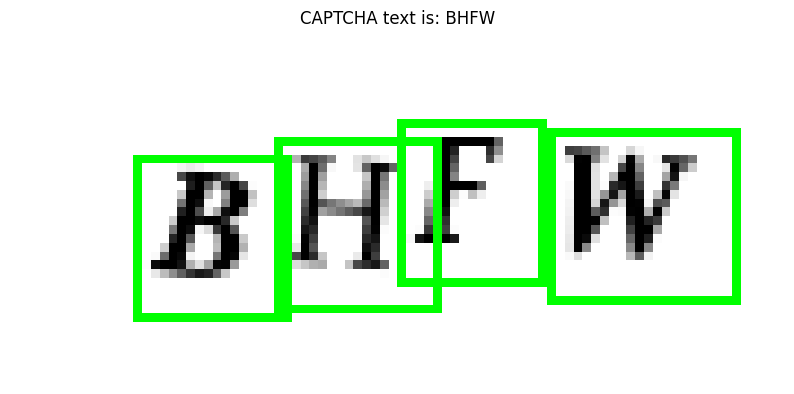

1/1 [==============================] - 0s 67ms/step


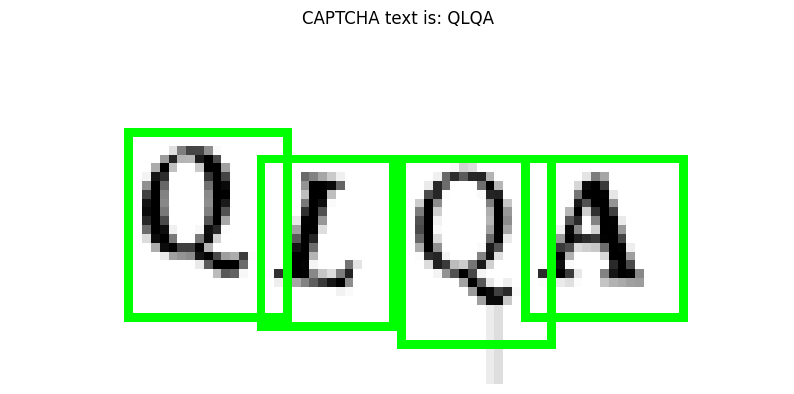

1/1 [==============================] - 0s 34ms/step


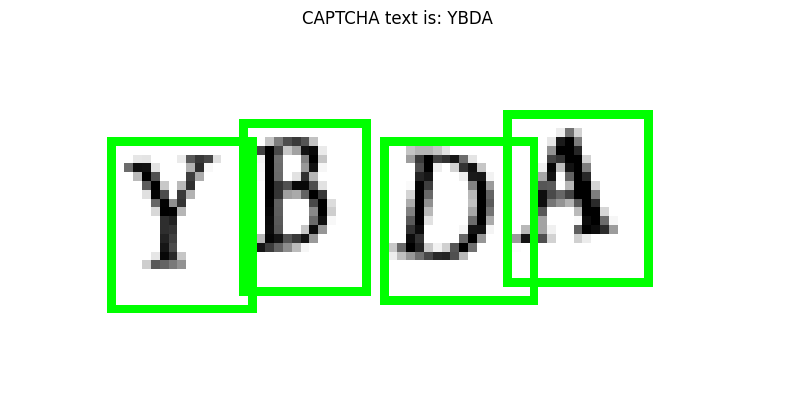

1/1 [==============================] - 0s 30ms/step


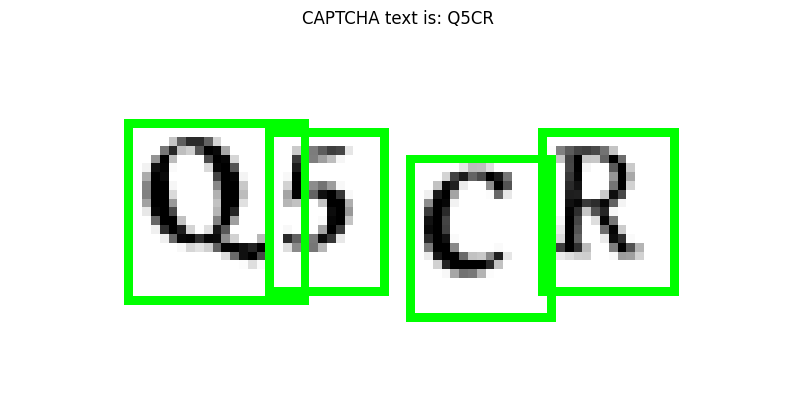

1/1 [==============================] - 0s 32ms/step


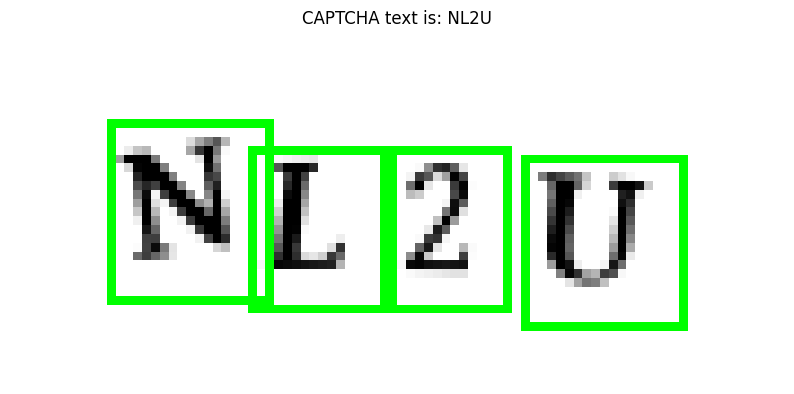

1/1 [==============================] - 0s 33ms/step


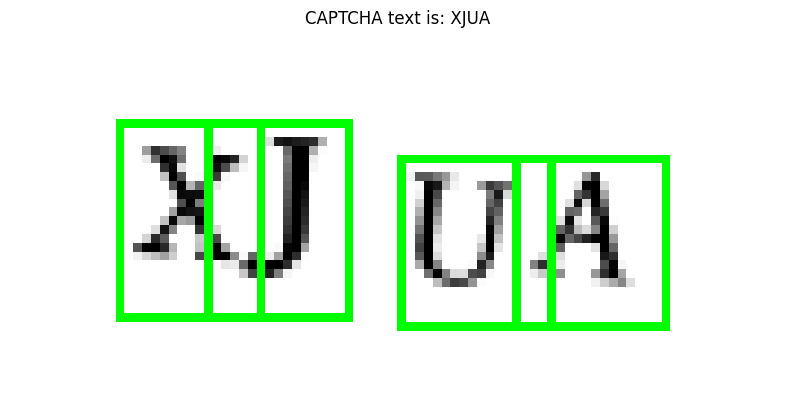

1/1 [==============================] - 0s 35ms/step


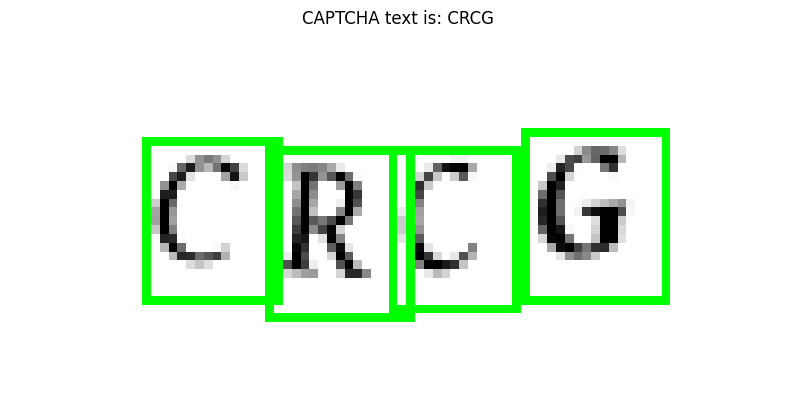

1/1 [==============================] - 0s 31ms/step


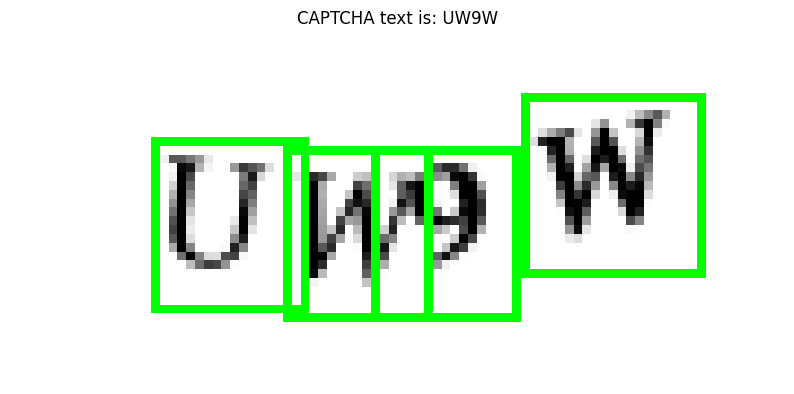

In [24]:
for image_file in captcha_image_files:
  # Convert to grayscale
  image = cv2.imread(image_file)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Add padding
  image = cv2.copyMakeBorder(image, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

  # Apply thresholding
  thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

  # Find contours
  contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  contours = contours[1] if imutils.is_cv3() else contours[0]

  letter_image_regions = []

  # Extract letter of each contours
  for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)

    # Detect if a contour contain 2 letter
    if w / h > 1.25:
      half_width = int(w / 2)
      letter_image_regions.append((x, y, half_width, h))
      letter_image_regions.append((x + half_width, y, half_width, h))
    else:
      letter_image_regions.append((x, y, w, h))

  if len(letter_image_regions) != 4:
    continue

  # Sort the image
  letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

  # Create an output image and a list to hold predicted letters
  output = cv2.merge([image] * 3)
  predictions = []

  # Loop over the letters
  for letter_bounding_box in letter_image_regions:
    x, y, w, h = letter_bounding_box

    # Extract the letter from the original image with a 2 pixel margin
    letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]

    # Re-size the letter to a 20x20 pixel
    letter_image = resize_to_fit(letter_image, 20, 20)

    # Turn the single image into 4d list of images
    letter_image = np.expand_dims(letter_image, axis=2)
    letter_image = np.expand_dims(letter_image, axis=0)

    # Use the model to predict
    prediction = model.predict(letter_image)

    # Convert one-hot prediction to normal letter
    letter = lb.inverse_transform(prediction)[0]
    predictions.append(letter)

    cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)

  # Print the captcha text
  captcha_text = "".join(predictions)

  # Show the image
  plt.figure(figsize=(10,5))
  plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
  plt.title(f"CAPTCHA text is: {captcha_text}")
  plt.axis('off')
  plt.show()